In [11]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torchvision.models import VGG16_Weights
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
from glob import glob
import imageio

In [12]:
transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [13]:
train_dataset = datasets.ImageFolder(
    'data/training',
    transform=transform
)
test_dataset = datasets.ImageFolder(
    'data/validation',
    transform=transform
)

In [14]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size
)

In [15]:
vgg = models.vgg16(weights=VGG16_Weights.DEFAULT)

In [16]:
class VGG16Features(nn.Module):
    def __init__(self, vgg):
        super(VGG16Features, self).__init__()
        self.vgg = vgg

    def forward(self, X):
        out = vgg.features(X)
        out = vgg.avgpool(out)
        out = out.view(out.size(0), -1)
        return out

In [17]:
vggf = VGG16Features(vgg)

In [18]:
out = vggf(torch.rand(1,3,224,224))
out.shape

torch.Size([1, 25088])

In [19]:
NTrain = len(train_dataset)
NTest = len(test_dataset)
NTrain, NTest

(3000, 1000)

In [20]:
D = out.shape[1]

In [21]:
X_train = np.zeros((NTrain, D))
y_train = np.zeros((NTrain, 1))
X_test = np.zeros((NTest, D))
y_test = np.zeros((NTest, 1))

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
vggf.to(device)

VGG16Features(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [23]:
# populate X_train and y_train
i = 0
with torch.no_grad():
    for inputs, targets in train_loader:
        # move data to gpu
        t0 = datetime.now()
        inputs = inputs.to(device)

        # get outputs
        output = vggf(inputs)

        # size of batch
        sz = len(output)

        # assign to X_train and y_train
        X_train[i:i + sz] = output.cpu().detach().numpy()
        y_train[i:i + sz] = targets.view(-1, 1).numpy()

        # increment i
        i += sz
        print(i)
        t1 = datetime.now()
        print(t1 - t0)

128
0:00:11.376758
256
0:00:10.164695
384
0:00:09.051458
512
0:00:09.062357
640
0:00:09.042219
768
0:00:09.063547
896
0:00:09.100396
1024
0:00:09.061365
1152
0:00:09.030192
1280
0:00:09.046648
1408
0:00:09.036640
1536
0:00:09.032140
1664
0:00:09.084263
1792
0:00:09.042750
1920
0:00:09.018027
2048
0:00:09.045670
2176
0:00:09.052524
2304
0:00:09.040832
2432
0:00:09.145055
2560
0:00:09.195011
2688
0:00:09.053525
2816
0:00:09.088580
2944
0:00:09.077084
3000
0:00:02.466666


In [37]:
# populate X_train and y_train
i = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        # move data to gpu
        t0 = datetime.now()
        inputs = inputs.to(device)

        # get outputs
        output = vggf(inputs)

        # size of batch
        sz = len(output)

        # assign to X_train and y_train
        X_test[i:i + sz] = output.cpu().detach().numpy()
        y_test[i:i + sz] = targets.view(-1, 1).numpy()

        # increment i
        i += sz
        print(i)
        t1 = datetime.now()
        print(t1 - t0)

128
0:00:09.373715
256
0:00:09.045140
384
0:00:09.051618
512
0:00:09.075218
640
0:00:09.177792
768
0:00:09.165259
896
0:00:09.259373
1000
0:00:08.577975


In [40]:
X_train.max(), X_train. min()

(61.944580078125, 0.0)

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

In [50]:
from sklearn.linear_model import LogisticRegression
logModel = LogisticRegression()
logModel.fit(X_train2, y_train.flatten())
print(f'train score: ', logModel.score(X_train2, y_train.flatten()))
print(f'test score: ', logModel.score(X_test2, y_test.flatten()))

train score:  1.0
test score:  0.982


In [52]:
model = nn.Linear(D, 1)

In [54]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

Linear(in_features=25088, out_features=1, bias=True)

In [68]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [58]:
# re create dataset - Move weight matrix to tensor
train_dataset2 = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train2.astype(np.float32)),
    torch.from_numpy(y_train.astype(np.float32))
)

test_dataset2 = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test2.astype(np.float32)),
    torch.from_numpy(y_test.astype(np.float32))
)

In [60]:
batch_size = 128
train_loader2 = torch.utils.data.DataLoader(
    train_dataset2,
    batch_size=batch_size,
    shuffle=True
)

test_loader2 = torch.utils.data.DataLoader(
    test_dataset2,
    batch_size=batch_size
)

In [64]:
def batch_grad(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Create initial theta
            optimizer.zero_grad()

            # Cal loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and update theta
            loss.backward()
            optimizer.step()

            # Append loss
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        train_losses[it] = train_loss

        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it + 1}/{epochs} Train loss: {train_loss:.4f} Test loss: {test_loss:.4f} Duration: {dt}')
    return train_losses, test_losses

In [72]:
train_losses, test_losses = batch_grad(model, criterion, optimizer, train_loader2, test_loader2, epochs=10)

Epoch0/10 Train loss: 0.1076 Test loss: 0.0495 Duration: 0:00:00.605822
Epoch1/10 Train loss: 0.0071 Test loss: 0.0502 Duration: 0:00:00.191248
Epoch2/10 Train loss: 0.0014 Test loss: 0.0486 Duration: 0:00:00.217145
Epoch3/10 Train loss: 0.0008 Test loss: 0.0480 Duration: 0:00:00.241184
Epoch4/10 Train loss: 0.0006 Test loss: 0.0478 Duration: 0:00:00.182602
Epoch5/10 Train loss: 0.0005 Test loss: 0.0477 Duration: 0:00:00.194246
Epoch6/10 Train loss: 0.0004 Test loss: 0.0476 Duration: 0:00:00.245093
Epoch7/10 Train loss: 0.0004 Test loss: 0.0475 Duration: 0:00:00.220573
Epoch8/10 Train loss: 0.0003 Test loss: 0.0475 Duration: 0:00:00.275392
Epoch9/10 Train loss: 0.0003 Test loss: 0.0475 Duration: 0:00:00.191243


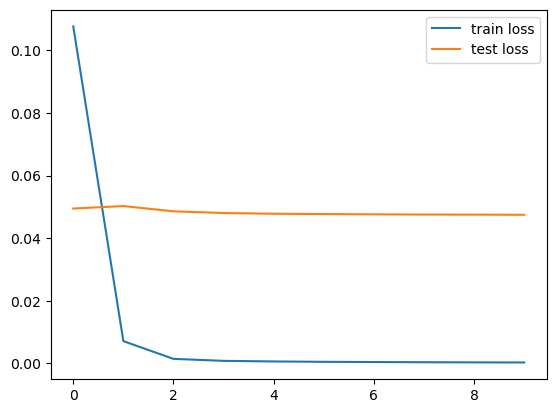

In [75]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend();

In [82]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader2:
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)

    predictions = (outputs > 0)

    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader2:
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)

    predictions = (outputs > 0)

    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f'train acc: {train_acc} test acc: {test_acc}')

train acc: 1.0 test acc: 0.984
